In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from util.expectiles import tauspace
import imputers

from environments.igt import IowaGamblingTask, TwoStepIowaGamblingTask

In [69]:
def train(env, agent, episodes=10000, render=True, log=False):
    if log: history = [agent.state()]
    for _ in tqdm.trange(episodes, unit="eps"):
        s = env.reset()
        done = False
        if render: env.render()
        while not done:
            a = agent.action(s)
            s_, r, done, _ = env.step(a)
            agent.update(s, a, r, s_, done)
            s = s_
            if render: env.render()
        if log: history.append(agent.state())
    if log: return history
    
def plot_log(history):
    states, tables = zip(*history[0].items())
    for i, (state, table) in enumerate(zip(states, tables)):
        m, k = table.shape
        fig, axes = plt.subplots(1, m, figsize=(4*m, 3), sharey=True, squeeze=False)
        data = np.stack([h[state] for h in history])
        for i in range(m):
            ax = axes[0, i]
            for j in range(k):
                ax.plot(data[:, i, j], color=plt.cm.viridis(j/k))
            ax.set_title("state {}, action {}".format(state, i))
            ax.set_xlabel("episodes")
        plt.show()

def experiment_igt(agent_class, episodes=200000, **kwargs):
    env = IowaGamblingTask(max_nrounds=1)
    agent = agent_class([env.action_space], **kwargs)
    log = train(env, agent, episodes=episodes, render=False, log=True)
    plot_log(log)

def experiment_igt2(agent_class, episodes=200000, **kwargs):
    env = TwoStepIowaGamblingTask(max_nrounds=1)
    agent = agent_class(env.action_spaces, **kwargs)
    log = train(env, agent, episodes=episodes, render=False, log=True)
    plot_log(log)

In [64]:
class QLearning:
    def __init__(self, action_spaces, ε=0.05, α=0.001, γ=1.0, random_state=None):
        self.Q = {s: np.zeros((action_spaces[s].size, 1)) for s in range(len(action_spaces))}
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
    def action(self, s):
        exploring = (self.rng.random() < self.ε)
        if exploring:
            return np.random.choice(self.Q[s].size)
        else:
            return np.argmax(self.Q[s])
    def update(self, s, a, r, s_, terminal):
        if terminal:
            # no next state
            self.Q[s][a] += self.α * (r - self.Q[s][a])
        else:
            a_ = np.argmax(self.Q[s_])
            self.Q[s][a] += self.α * (r + self.γ*self.Q[s_][a_] - self.Q[s][a])
    def state(self):
        return copy.deepcopy(self.Q)

In [72]:
class ExpectileQLearning:
    def __init__(self, action_spaces, n_expectiles, imputer, ε=0.05, α=0.001, γ=1.0,
                 random_state=None, lrm=False):
        self.k = n_expectiles
        self.τ = tauspace(self.k)
        self.i = self.k // 2
        self.E = {s: np.zeros((action_spaces[s].size, self.k))
                  for s in range(len(action_spaces))}
        self.I = imputer
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
        if lrm:
            self.lrm = 1/np.sqrt(self.τ * (1-self.τ))
        else:
            self.lrm = 2
    def action(self, s):
        exploring = (self.rng.random() < self.ε)
        if exploring:
            return np.random.choice(self.E[s].shape[0])
        else:
            return np.argmax(self.E[s][:, self.i])
    def update(self, s, a, r, s_, terminal):
        # transform
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = np.argmax(self.E[s_][:, self.i])
            X = r + self.γ * self.I.fit(self.E[s_][a_], self.τ).sample(self.k)
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s][a]
        scale = np.abs((rpe < 0) - self.τ)
        self.E[s][a] += self.α * self.lrm / self.k * np.sum(scale * rpe, axis=0)
    def state(self):
        return copy.deepcopy(self.E)

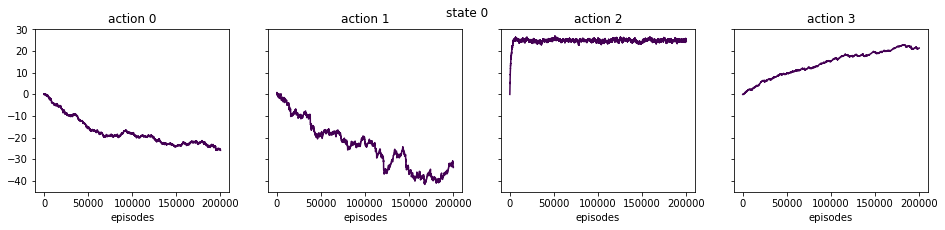

In [65]:
experiment_igt(QLearning)

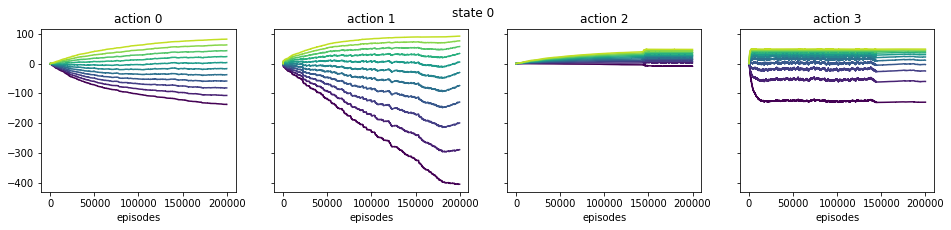

In [66]:
experiment_igt(ExpectileQLearning, n_expectiles=11, imputer=imputers.OptBasedImputer())

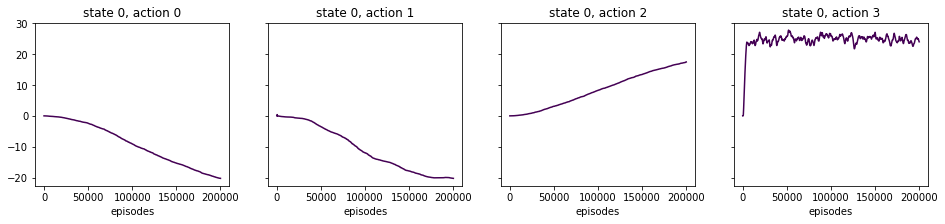

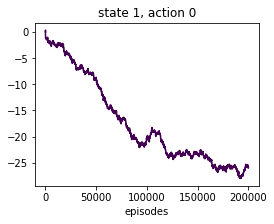

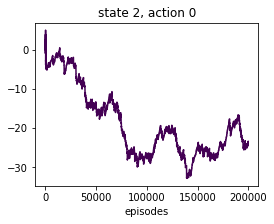

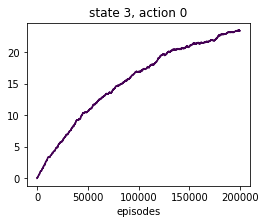

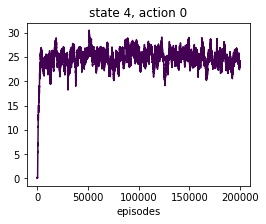

In [77]:
experiment_igt2(QLearning)

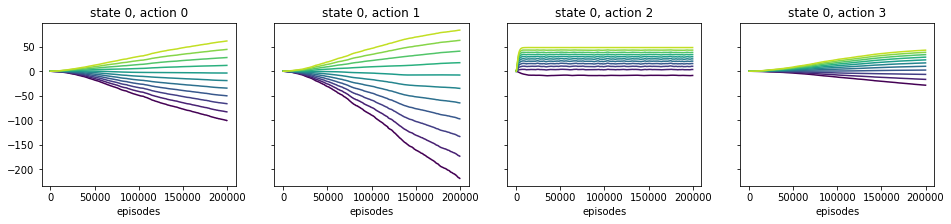

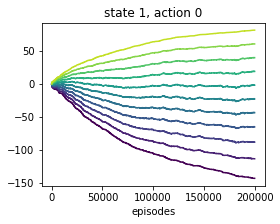

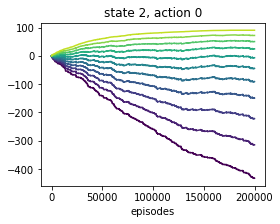

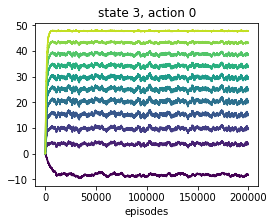

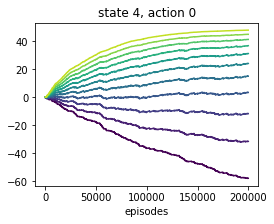

In [78]:
experiment_igt2(ExpectileQLearning, n_expectiles=11, imputer=imputers.OptBasedImputer())